In [1]:
from gnuradio.filter import firdes
#import sip
from gnuradio import gr
from gnuradio import blocks
from gnuradio.fft import window

from gnuradio.eng_arg import eng_float, intx
from gnuradio import eng_notation
from gnuradio import soapy

import sys
#import signal
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging

from scipy.signal import spectrogram
import rf_tools_gnuradio as rftgr

In [2]:
# print the current settings of PYTHONPATH
print(f"The PYTHONPATH is: {sys.path}")
# setup logging to save to a file
logging_file = Path.home() / 'log' / 'sdr_get_samples.log'

logging.basicConfig(filename=logging_file, level=logging.DEBUG, format='%(asctime)s %(levelname)s %(funcName)s: %(message)s')

The PYTHONPATH is: ['/home/user/src/rf_analysis', '', '/home/user/src/rf_analysis/.rf_analysis/lib/python3.10/site-packages', '/usr/lib/python3', '/usr/lib/python3/dist-packages', '/home/user/.pyenv/versions/3.10.4/lib/python310.zip', '/home/user/.pyenv/versions/3.10.4/lib/python3.10', '/home/user/.pyenv/versions/3.10.4/lib/python3.10/lib-dynload']


In [5]:
sample_rate = 1_024_000
center_freq_Hz = 84_000_000
time_to_collect_sec = 10

new_db_file_path = Path.home() / 'data' / 'sdr_db_t1'
(x, full_file_name, full_json_file_name)=rftgr.sdr_get_samples(sample_rate = sample_rate, center_freq_Hz = center_freq_Hz, time_to_collect_sec = time_to_collect_sec, sdr_type = "rtlsdr", file_path = new_db_file_path, create_directory = True)
print(f"Captured {x.shape} samples and saved in {full_file_name} with metadata in {full_json_file_name}.")

[INFO] Opening Generic RTL2832U OEM :: 00000001...
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
[INFO] Using format CF32.


Captured (10240000,) samples and saved in /home/user/data/sdr_db_t1/sdr_rtlsdr_fc_84000000_fs_1024000_20230827_144026.npy with metadata in /home/user/data/sdr_db_t1/sdr_rtlsdr_fc_84000000_fs_1024000_20230827_144026.json.


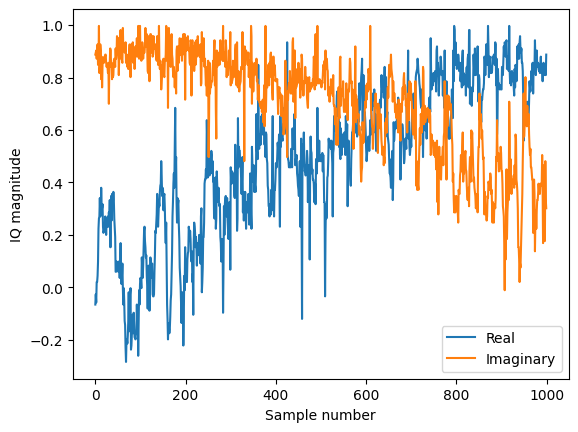

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.real(x[0:1000]))
plt.plot(np.imag(x[0:1000]))
plt.xlabel('Sample number')
plt.ylabel('IQ magnitude')
plt.legend(['Real', 'Imaginary'])
plt.show()

In [8]:
from scipy.signal import spectrogram
(frequencies, times, spectrogram_data)= spectrogram(x, fs=sample_rate, nperseg=128, noverlap=64,return_onesided=False, mode='complex', scaling='density')

# Why fftshift is needed https://github.com/scipy/scipy/issues/5757#issuecomment-259482424
frequencies = np.fft.fftshift(frequencies)
# add the center_freq_Hz to the frequencies to get the actual frequency values
frequencies = frequencies + center_freq_Hz
# convert to MHz
frequencies = frequencies / 1e6

spectrogram_data = np.fft.fftshift(spectrogram_data, axes=0)

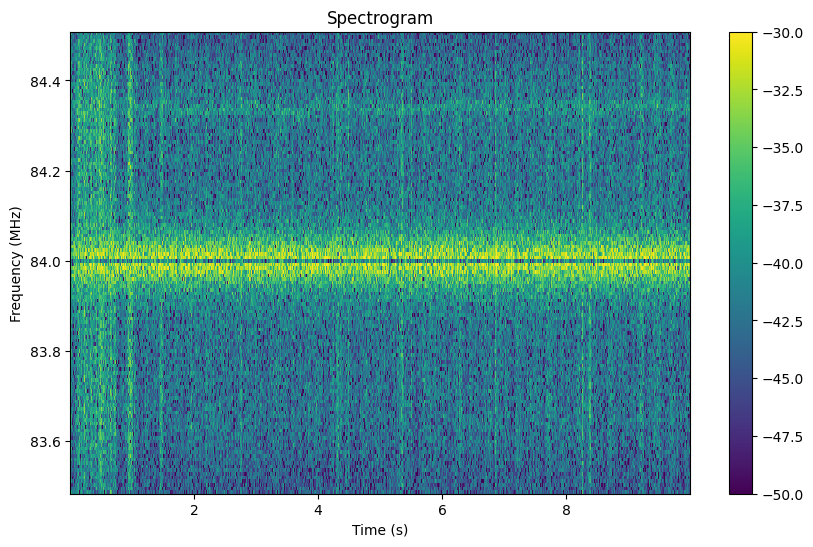

In [9]:
# create a unique colormap to use for the spectrogram plot
cmap = plt.get_cmap('viridis')

fig_width = 10
fig_height = 6

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
ph=ax.pcolormesh(times,frequencies, 10*np.log10(np.abs(spectrogram_data)), cmap=cmap)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (MHz)')
#set the colorbar
fig.colorbar(ph, ax=ax)

ax.set_title('Spectrogram')

# set the color bar limits to the range of the data values
#ph.set_clim(np.min(10*np.log10(np.abs(spectrogram_data))), np.max(10*np.log10(np.abs(spectrogram_data))))
ph.set_clim(-50, -30)

plt.show()

/home/user/src/rf_analysis/.rf_analysis/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


peaks = [63]


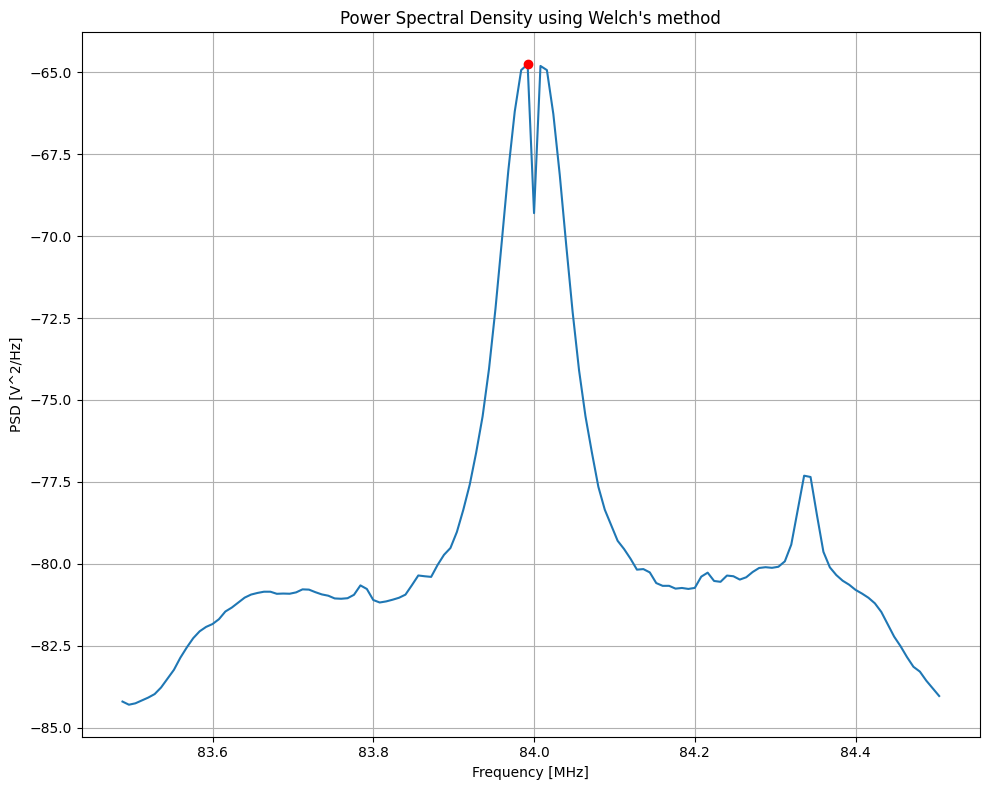

: 

In [10]:
from scipy.signal import welch, find_peaks
# Compute the power spectral density using welch
frequencies_welch, Pxx = welch(x, fs=sample_rate, nperseg=128, noverlap=64)
# FFT shift the results for centering around zero frequency
frequencies_welch_shifted = np.fft.fftshift(frequencies_welch) + center_freq_Hz
Pxx_shifted = np.fft.fftshift(Pxx)
Pxx_shifted_dB=10*np.log10(Pxx_shifted)
frequencies_welch_shifted_MHz=frequencies_welch_shifted/1e6

# Create a figure with subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
axs=[ax]

# Peak detection
height_threshold = 0.5  # Set a suitable threshold based on your data
min_distance = 5  # Set minimum number of samples between peaks

peaks, _ = find_peaks(Pxx_shifted_dB, prominence=1, width=5)
print(f"peaks = {peaks}")
# Plot the power spectral density
axs[0].plot(frequencies_welch_shifted_MHz,Pxx_shifted_dB )
axs[0].plot(frequencies_welch_shifted_MHz[peaks], Pxx_shifted_dB[peaks], 'ro')
axs[0].set_ylabel('PSD [V^2/Hz]')
axs[0].set_xlabel('Frequency [MHz]')
axs[0].set_title('Power Spectral Density using Welch\'s method')
axs[0].grid(True)

plt.tight_layout()
plt.show()